# Chapter 11

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from pathlib import Path

from matplotlib import pyplot as plt, dates as mdates
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# omd
import datetime
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt
import omdutils as omd

importlib.reload(tt)

path = Path('/home/oliver/Documents/Data')
print('timetools version: {}'.format(tt.__version__))
print('omdutils version: {}'.format(omd.__version__))
print('statsmodels version: {}'.format(sm.__version__))

timetools version: 10.09.2022
omdutils version: 8.6.2022
statsmodels version: 0.13.2


In [3]:
# Run this cell only once to create the dataset and save it in Datasets database
df = pd.read_csv('../CH11/data/AusAntidiabeticDrug.csv')
omd.to_sqlite(df, 'AusAntidiabeticDrug', str(path / 'Datasets'))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      204 non-null    object 
 1   y       204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [4]:
df = omd.from_sqlite('select * from AusAntidiabeticDrug', str(path / 'Datasets'))
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)
df.rename(columns={'y':'prescriptions'}, inplace=True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 1991-07-01 to 2008-06-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   prescriptions  204 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


,prescriptions
ds,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


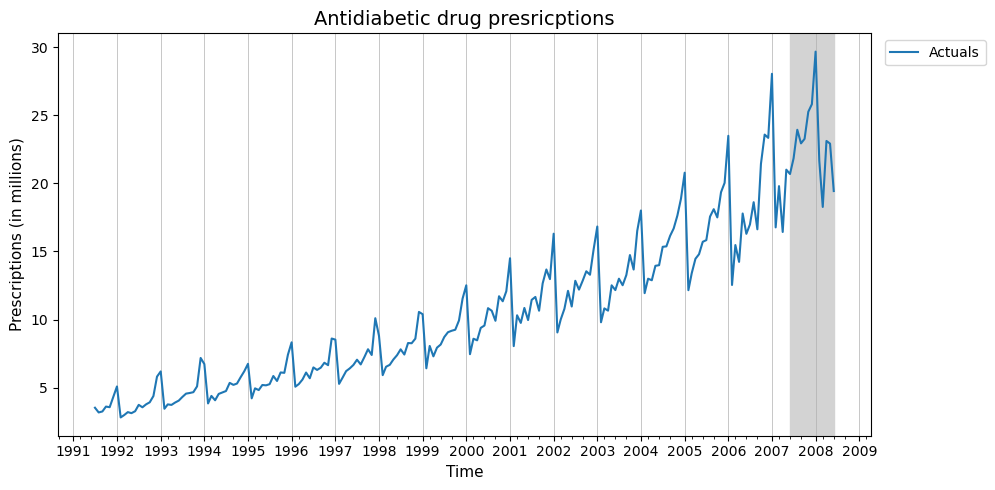

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df['prescriptions'], label='Actuals', zorder=3)
ax.axvspan(xmin='2007-06-01', xmax='2008-06-01', color='lightgrey')
ax.set_xlabel('Time', fontsize=11)
ax.set_ylabel('Prescriptions (in millions)', fontsize=11)
ax.set_title('Antidiabetic drug presricptions', fontsize=14)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_minor_locator(mdates.MonthLocator([3,6,9]))
ax.grid(axis='x', lw=0.5)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0))
plt.tight_layout()
plt.show()

## Seasonal Decomposition 
There is annual seasonality

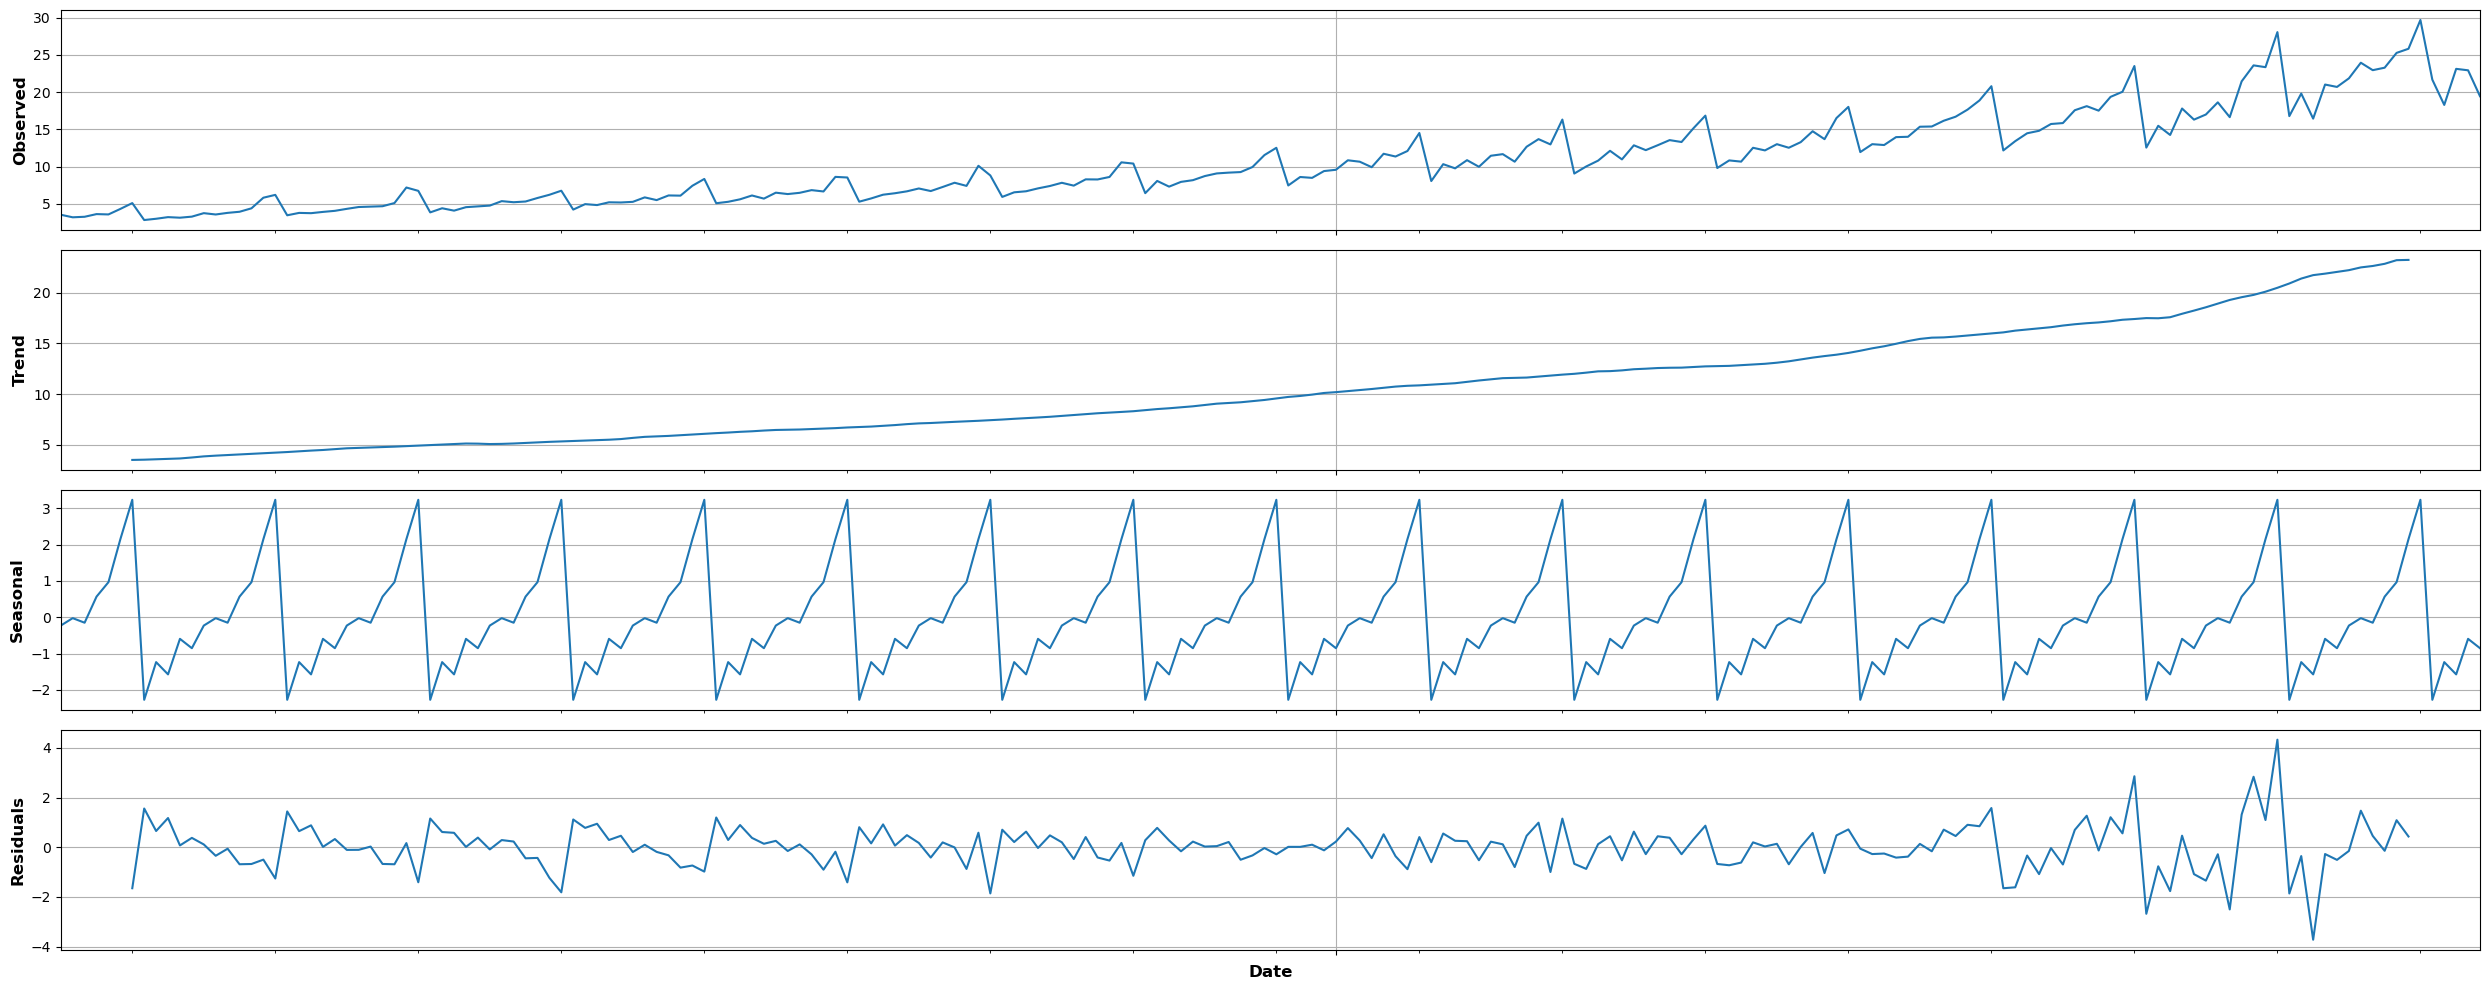

In [6]:
tt.seasonal_decomp(df['prescriptions'], period=12)

## Stationarity  
stationary at d=0 and D=12

In [7]:
tt.adf_v2(df['prescriptions'])

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                   3.145186
p-value                          1.000000
#Lags Used                      15.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64

The time series is not stationary.


Differenced?  d=0



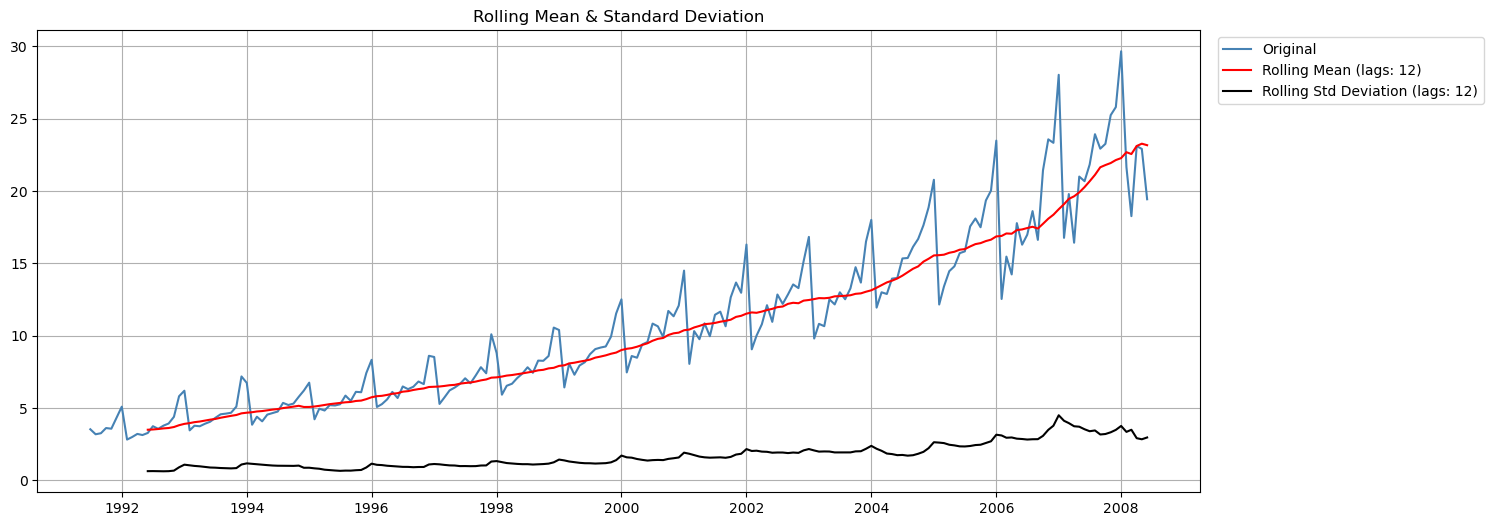

In [8]:
tt.plot_for_stationary(df['prescriptions'], lags=12)

In [9]:
tt.adf_v2(df['prescriptions'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                  -2.495172
p-value                          0.116653
#Lags Used                      15.000000
Number of Observations Used    187.000000
Critical Value (1%)             -3.465812
Critical Value (5%)             -2.877123
Critical Value (10%)            -2.575077
dtype: float64

The time series is not stationary.


Differenced?  d=1



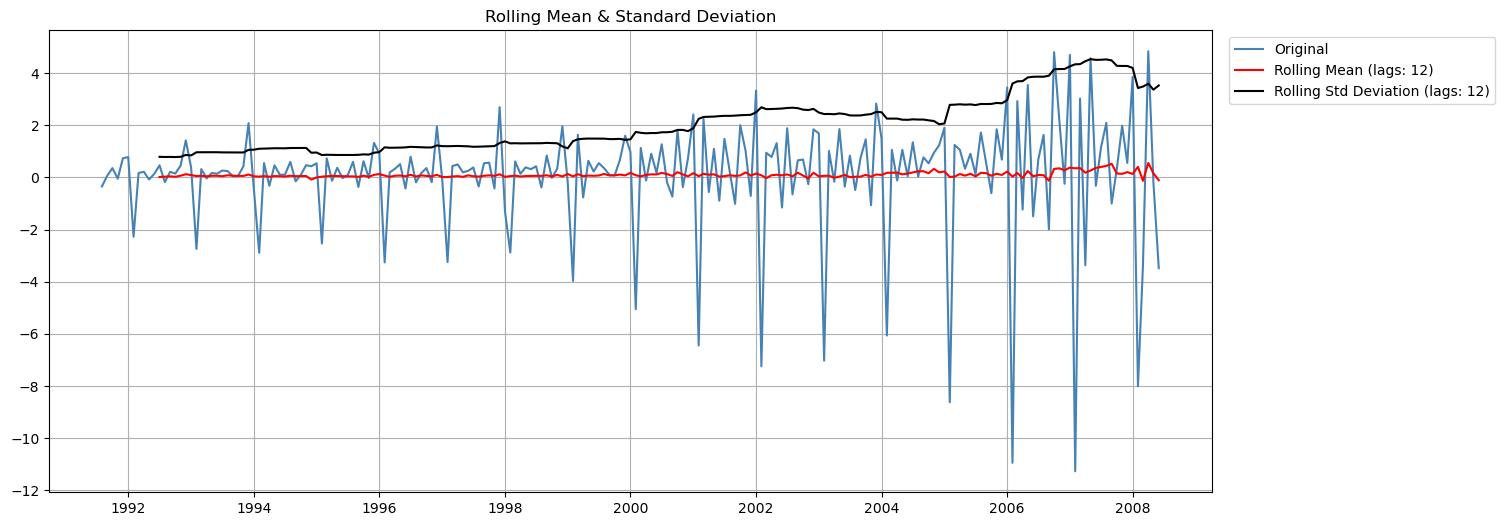

In [10]:
tt.plot_for_stationary(df['prescriptions'], diff=1, lags=12)

Test if `seasonal differencing` will make timeseries stationary.  
  
d=1  
D=12

In [11]:
tt.adf_v2(df['prescriptions'].diff(1)[1:], diff=12)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=12

Test Statistic                 -19.848440
p-value                          0.000000
#Lags Used                      15.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64

The time series is stationary.


Differenced?  d=12



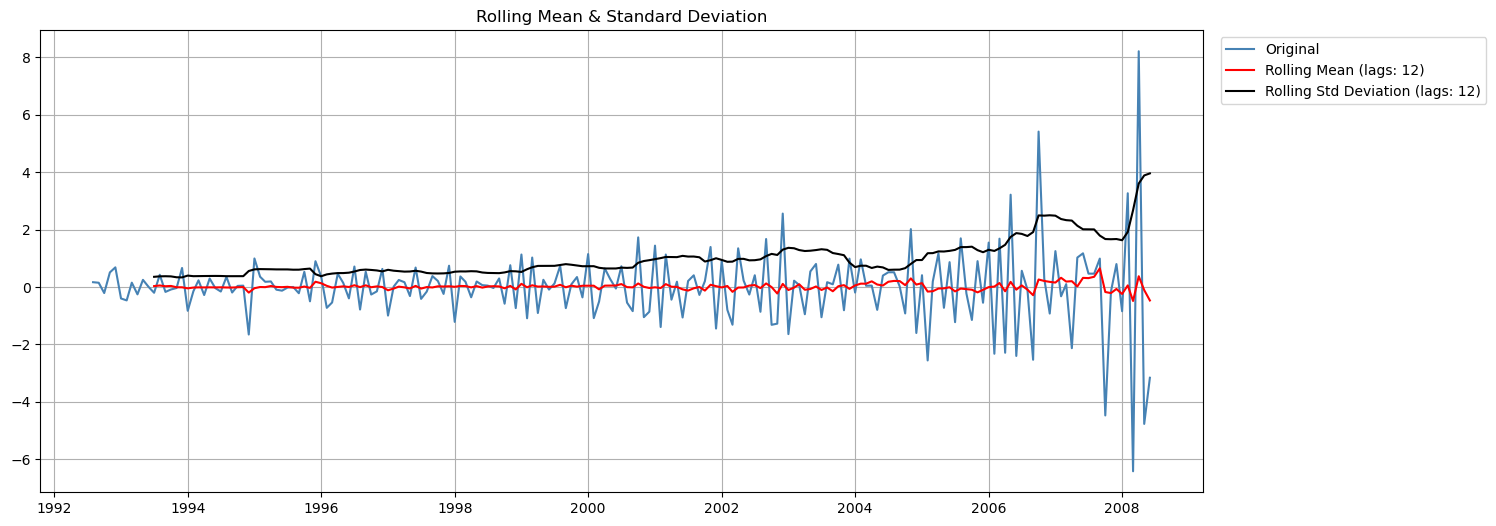

In [12]:
tt.plot_for_stationary(df['prescriptions'].diff(1)[1:], diff=12, lags=12)

## Best fit (AIC)

### Train & Test datasets

In [13]:
df_train = df[:-12]
df_test = df[-12:]
df_test

,prescriptions
ds,
2007-07-01,21.834890
2007-08-01,23.930204
2007-09-01,22.930357
2007-10-01,23.263340
2007-11-01,25.250030
2007-12-01,25.806090
2008-01-01,29.665356
2008-02-01,21.654285
2008-03-01,18.264945


In [14]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)

P = range(0, 3, 1)
D = 12
Q = range(0, 3, 1)

s = 12

parameters_list = list(product(p, q, P, Q))
parameters_list[:4]

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 1, 0)]

In [15]:
tt.optimize_SARIMA(df_train, parameters_list, d, D, s=s)

  0%|          | 0/1521 [00:00<?, ?it/s]